# Hydrocarbon-Air Species Sequence
This Jupyter Notebook was written by Dan Haworth. It is intended as a tutorial to be used in parallel with Chapter 5 of the book "An Introduction to Combustion: Concepts and Applications" by Stephen R. Turns and Daniel C. Haworth. That book is referred to as "Turns 4th ed." throughout this Notebook.

This Notebook was last updated 11 February 2020.

The objective of this tutorial is to provide an example of the time sequence of disappearance/appearance of different species (molecules) over the course of converting a hydrocarbon-air reactants mixture to an equilibrium products mixture. We will use the thermodynamic properties and the reaction mechanism that are included in gri30.cti.

The reader should be familiar with the material in the Chapter 4 Notebooks before working through this Notebook.

## 1. Motivation and background

Intermediate species (species that are neither in the initial fuel+oxidizer reactants, nor in the final equilibrium products) play important roles in the combustion process. For hydrocarbon-fuel/air systems, the intermediates include both radicals and stable or quasi-stable species. We have seen some of these intermediate species in earlier tutorial Notebooks. A general sequence for alkane fuels containing at least three carbon atoms is discussed in Chapter 5 of Turns 4th ed., and methane combustion is discussed separately in a subsequent section of Chapter 5. 

Figure 5.2 of Turns 4th ed. shows an example of a spatial sequence of species mole fractions for propane fuel in a steady-flow reactor. A description of such a reactor, including the governing equations, can be found in Chapter 6. Here we will consider the time evolution of species for an isothermal constant-pressure reactor. To do this, we use the "IdealGasConstPressureReactor" object as in an earlier tutorial Notebook, but we disable the solution of the energy equation, so that the temperature remains constant at its initial value. The time evolution of species composition in the constant-pressure reactor is then qualitatively similar to the spatial evolution of species composition for the steady-flow reactor.

## 2. Time evolution of species in a constant-pressure, isothermal reactor

In [1]:
# access modules
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# report Cantera version
print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.4.0


In [2]:
# define an ideal-gas mixture named "gas" using Cantera's "Solution" object and GRI-Mech 3.0
gas = ct.Solution('gri30.cti')

In [3]:
# list the available species, for future reference
gas.species()

[<Species H2>,
 <Species H>,
 <Species O>,
 <Species O2>,
 <Species OH>,
 <Species H2O>,
 <Species HO2>,
 <Species H2O2>,
 <Species C>,
 <Species CH>,
 <Species CH2>,
 <Species CH2(S)>,
 <Species CH3>,
 <Species CH4>,
 <Species CO>,
 <Species CO2>,
 <Species HCO>,
 <Species CH2O>,
 <Species CH2OH>,
 <Species CH3O>,
 <Species CH3OH>,
 <Species C2H>,
 <Species C2H2>,
 <Species C2H3>,
 <Species C2H4>,
 <Species C2H5>,
 <Species C2H6>,
 <Species HCCO>,
 <Species CH2CO>,
 <Species HCCOH>,
 <Species N>,
 <Species NH>,
 <Species NH2>,
 <Species NH3>,
 <Species NNH>,
 <Species NO>,
 <Species NO2>,
 <Species N2O>,
 <Species HNO>,
 <Species CN>,
 <Species HCN>,
 <Species H2CN>,
 <Species HCNN>,
 <Species HCNO>,
 <Species HOCN>,
 <Species HNCO>,
 <Species NCO>,
 <Species N2>,
 <Species AR>,
 <Species C3H7>,
 <Species C3H8>,
 <Species CH2CHO>,
 <Species CH3CHO>]

In [4]:
# initialize the gas mixture
# here we consider a fuel-lean propane-air mixture at 1000 K and 1 atm
T_0  = 1000.
p_0  = ct.one_atm

fuel = 'C3H8'
air  = 'O2:1.0 N2:3.76'
phi  = 0.8

gas.TP = T_0, p_0
gas.set_equivalence_ratio(phi,fuel,air)

# print the current state of the gas mixture
gas()


  gri30:

       temperature            1000  K
          pressure          101325  Pa
           density        0.357634  kg/m^3
  mean mol. weight         29.3465  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      7.0376e+05        2.065e+07     J
   internal energy      4.2044e+05        1.234e+07     J
           entropy          8270.7        2.427e+05     J/K
    Gibbs function      -7.567e+06       -2.221e+08     J
 heat capacity c_p          1288.3        3.781e+04     J/K
 heat capacity c_v          1004.9        2.949e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                O2       0.203252         0.221621          -28.159
                N2       0.764228         0.729513         -25.1194
              C3H8      0.0325203        0.0488655         -54.9755
     [  +50 minor]        

In [5]:
# define a reactor that is filled with the ideal-gas mixture "gas",
#   and name it "Constant-pressure reactor"
# note that the solution of the energy equation is disabled, so that the temperature will remain constant
reactor = ct.IdealGasConstPressureReactor(contents=gas,name="Constant-pressure reactor",energy="off")

# add "reactor" to a reactor network named "reactorNetwork:"
reactorNetwork = ct.ReactorNet([reactor])

# create a list of all variables (named "stateVariableNames") for which we will compute and store time-dependent data
#   as the system evolves in time
stateVariableNames = [reactor.component_name(i) for i in range(reactor.n_vars)]

# create a Pandas DataFrame named "timeHistory", using the state variable names as column headings
timeHistory = pd.DataFrame(columns=stateVariableNames)

# add a row to "timeHistory" with the initial condition
t = 0.
timeHistory.loc[t] = reactor.get_state()

# print "timeHistory"
# currently it contains the column headings and the initial condition
timeHistory

,mass,temperature,H2,H,O,O2,OH,H2O,HO2,H2O2,...,HCNO,HOCN,HNCO,NCO,N2,AR,C3H7,C3H8,CH2CHO,CH3CHO
0.0,0.357634,1000.0,0.0,0.0,0.0,0.221621,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.729513,0.0,0.0,0.048866,0.0,0.0


In [6]:
# specify the integration end time in seconds
t_end = 5.0 # (s)

# get the current computer time "ctim0"
ctim0 = time.time()

# perform the time integration
counter = 1;
while(t <= t_end):
    t = reactorNetwork.step()
# save the reactor state "timeHistory" once every 5 time steps,
    if (counter%5 == 0):
        timeHistory.loc[t] = reactor.get_state()
    counter+=1

# make sure that the final time step is included in timeHistory
timeHistory.loc[t] = reactor.get_state()

# the computer time needed to perform the integration is then the difference between ctim1 and ctim0
ctim1 = time.time()
ctime = ctim1 - ctim0

# print the final time and computer time required
print('Reached time {:.3e} seconds. Needed {:3.2f}s to compute'.format(t,ctime))

Reached time 5.005e+00 seconds. Needed 0.92s to compute


In [7]:
# save the time history to an Excel-compatible file, if desired
#timeHistory.to_csv("time_history.csv")

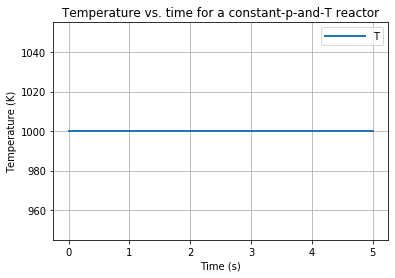

In [8]:
# plot the time evolution of temperature
fig, ax = plt.subplots()
ax.plot(timeHistory.index, timeHistory['temperature'], label='T', lw=2)
ax.set(xlabel='Time (s)',
       ylabel='Temperature (K)',
       title ='Temperature vs. time for a constant-p-and-T reactor')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("T_vs_t_pTconst.pdf")

This confirms that the temperature remains constant at its initial value.

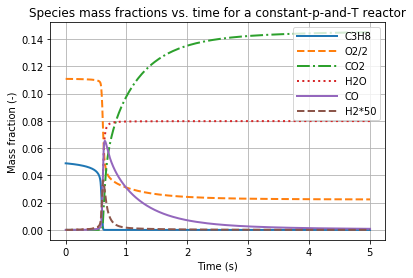

In [9]:
# plot the time evolution of several species mass fractions
fig, ax = plt.subplots()
ax.plot(timeHistory.index, timeHistory['C3H8'],   label='C3H8',  ls='solid',   lw=2)
ax.plot(timeHistory.index, timeHistory['O2']/2.,  label='O2/2',  ls='dashed',  lw=2)
ax.plot(timeHistory.index, timeHistory['CO2'],    label='CO2',   ls='dashdot', lw=2)
ax.plot(timeHistory.index, timeHistory['H2O'],    label='H2O',   ls='dotted',  lw=2)
ax.plot(timeHistory.index, timeHistory['CO'],     label='CO',    ls='solid',   lw=2)
ax.plot(timeHistory.index, timeHistory['H2']*50., label='H2*50', ls='dashed',  lw=2)
ax.set(xlabel='Time (s)',
       ylabel='Mass fraction (-)',
       title ='Species mass fractions vs. time for a constant-p-and-T reactor')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("Y1_vs_t_pTconst.pdf")

This figure emphasizes the slow conversion of CO to CO2, compared to the initial fuel breakdown. In contrast, the product H2O is formed relatively quickly, and there is little intermediate H2. Note that here we have plotted species mass fractions rather than mole fractions. The mole fraction of H2 in the mixture is considerably higher than its mass fraction, by a factor of the molecular weight of the mixture (approximately 29 kg/kmol) divided by the molecular weight of H2 (approximately 2 kg/kmol).

As emphasized in the discussion of Figure 5.2, olefins (chain hydrocarbon molecules having one double carbon-carbon bond) are an important class of intermediate species in the oxidation of an alkane fuel. That includes C2H4: ethene, or ethylene. Note that larger olefins such as C3H6 and C4H8 are not included in GRI-Mech 3.0. 

Other hydrocarbon species noted in the general scheme for alkanes outlined in Chapter 5 are C2H5, CH3, and C3H7; there are two isomers of the latter, but the two isomers are not distinguished in gri30.cti. Formyl radical (HCO) and formaldehyde (CH2O) are also mentioned.

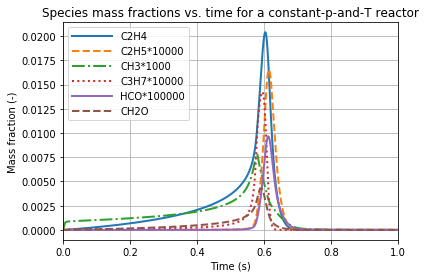

In [10]:
# plot the time evolution of several species mass fractions
# limit the time axis to the first 1 s, since the amounts of these species are negligible after that time
fig, ax = plt.subplots()
ax.plot(timeHistory.index, timeHistory['C2H4'],       label='C2H4',       ls='solid',   lw=2)
ax.plot(timeHistory.index, timeHistory['C2H5']*10000, label='C2H5*10000', ls='dashed',  lw=2)
ax.plot(timeHistory.index, timeHistory['CH3']*1000,   label='CH3*1000',   ls='dashdot', lw=2)
ax.plot(timeHistory.index, timeHistory['C3H7']*10000, label='C3H7*10000', ls='dotted',  lw=2)
ax.plot(timeHistory.index, timeHistory['HCO']*100000, label='HCO*100000', ls='solid',   lw=2)
ax.plot(timeHistory.index, timeHistory['CH2O'],       label='CH2O',       ls='dashed',  lw=2)

ax.set(xlim=(0.,1.0),
       xlabel='Time (s)',
       ylabel='Mass fraction (-)',
       title ='Species mass fractions vs. time for a constant-p-and-T reactor')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("Y2_vs_t_pTconst.pdf")

Note that the relative magnitudes of the different intermediates are very different. The mass fractions of C2H4 and CH2O are much higher than those of the other molecules plotted here. The different species mass fractions also peak at slightly different instants in time. 

Other key species in the process are the radicals H, O, and OH.

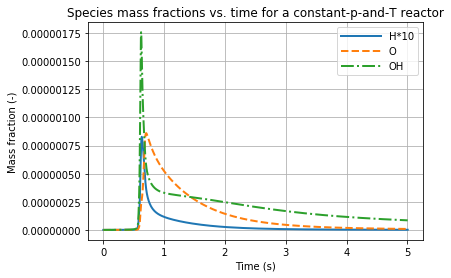

In [11]:
# plot the time evolution of several species mass fractions
fig, ax = plt.subplots()
ax.plot(timeHistory.index, timeHistory['H']*10, label='H*10', ls='solid',   lw=2)
ax.plot(timeHistory.index, timeHistory['O'],    label='O',    ls='dashed',  lw=2)
ax.plot(timeHistory.index, timeHistory['OH'],   label='OH',   ls='dashdot', lw=2)

ax.set(xlabel='Time (s)',
       ylabel='Mass fraction (-)',
       title ='Species mass fractions vs. time for a constant-p-and-T reactor')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("Y3_vs_t_pTconst.pdf")

In contrast to the species shown in the previous figure, the mass fractions of these three species rise relatively abruptly toward their peak values, then fall off slowly toward their final values. Note that the system has not quite reached equilibrium (the mass fraction of OH is still dropping), even after 5 s.

The quantitative results (time evolution of species mass or mole fractions) will vary with the initial pressure, temperature, and reactant composition and with the type of combustion process considered. Here we have considered reaction at constant pressure and temperature. In contrast to the constant-volume and constant-pressure systems considered in early tutorial Notebooks, the present system is not adiabatic; there must be heat transfer to maintain constant mixture pressure and temperature as the chemical reactions occur. 

Here we have considered a fuel-lean reactant mixture. In the case of a fuel-rich reactant mixture, different reaction pathways and intermediate species can be important. In particular, "pyrolysis" reactions (high-temperature fuel decomposition reactions in the absence of oxygen) that lead to high-molecular-weight species including polycyclic aromatic hydrocarbons (PAHs) can occur. Such reactions and species are not considered in GRI-Mech 3.0